# Sentiment Analysis Between Communities

## Preprocessing

In [1]:
import pandas as pd
import numpy as np
import networkx as nx
import community.community_louvain as community_louvain
import matplotlib.pyplot as plt
import re

#### Load data, split post properties into columns, create networkx graphs

In [2]:
# load the data
network_file = "data/soc-redditHyperlinks-body.tsv"
political_file = "data/subreddits.txt"

df_full = pd.read_csv(network_file, sep="\t")

# separate post properties into different columns
post_colnames_df = pd.read_csv("post_properties_column_names.csv")
col_list = list(post_colnames_df['Colname'].values)
df_full[col_list] = df_full.loc[:,'PROPERTIES'].str.split(',', expand=True)
df_full[col_list] = df_full[col_list].astype(float) # correct datatype


## filter by political subreddits
# read in political subs
with open('data/subreddits.txt', 'r') as f:
    political_subs = f.readlines()
political_subs = [sub.rstrip('\n') for sub in political_subs]
regex = re.compile(r'(politic|trump|biden|democrat|republican|liberal|conservative|progressive|socialist|libertarian|election|vote|campaign|maga|antifa|obama|sanders|rights|reform|policy|government|senate|president)', re.IGNORECASE)
dynamic_political_subs = [sub for sub in df_full["SOURCE_SUBREDDIT"].unique() if regex.search(sub)]
political_subs.extend(dynamic_political_subs)

df = pd.read_csv('data/filtered_network.csv')
to_drop = ['devotedmap', 'devoted', 'reformedhumor', 
           'reformed', 'mtaugustajustice', 
           'justiceleague', 'injustice',
           'antifa', 'enoughantifaspam',
            'mmt_economics', 'ronpaul',
            'liberalgunowners', 'guncontrol'
          ]
df = df.drop(df[df['SOURCE_SUBREDDIT'].isin(to_drop) | df['TARGET_SUBREDDIT'].isin(to_drop)].index)

# separate post properties into different columns
df[col_list] = df.loc[:,'PROPERTIES'].str.split(',', expand=True)
df[col_list] = df[col_list].astype(float) # correct datatype

# filter dataframe 
source_is_political = df_full["SOURCE_SUBREDDIT"].isin(political_subs)
target_is_political = df_full["TARGET_SUBREDDIT"].isin(political_subs)

# keep only connections where both are political
# df = df_full[source_is_political & target_is_political]
# df = df[df['SOURCE_SUBREDDIT'].isin(clustering_embed['subreddit']) & df['TARGET_SUBREDDIT'].isin(clustering_embed['subreddit'])]
df_psource = df_full[source_is_political]
df_ptarget = df_full[target_is_political]

# create graphs
source = "SOURCE_SUBREDDIT"
target = "TARGET_SUBREDDIT"
edgelist = df.loc[:, [source, target]].copy()
edgelist_df = edgelist.drop_duplicates().copy()
edgelist_df["count"] = edgelist.groupby([source, target]).transform("size")
# add link sentiments
df_counts = df.groupby([source, target])['LINK_SENTIMENT'].value_counts().reset_index()
links = df_counts.groupby(['SOURCE_SUBREDDIT', 'TARGET_SUBREDDIT', 'LINK_SENTIMENT'])['count'].sum().unstack(fill_value=0).reset_index().rename(columns={1: 'POSITIVE', -1: 'NEGATIVE'})
edgelist_df = edgelist_df.merge(links, how='inner', on=[source,target])
edgelist_df["LINK_SENTIMENT"] = edgelist_df["POSITIVE"] - edgelist_df["NEGATIVE"]
G_directed = nx.from_pandas_edgelist(edgelist_df, 
                                     source=source, target=target, 
                                     create_using=nx.DiGraph(),
                                     edge_attr=["count", "POSITIVE", "NEGATIVE", "LINK_SENTIMENT"])
G_undirected = G_directed.to_undirected()

In [3]:
len(political_subs)

1088

#### Use Louvain Community Detection

In [4]:
# Compute the best partition
# partition = community_louvain.best_partition(G_undirected, weight='count')
def best_louvain_partition(G):

    best_modularity = -1
    best_partition = None
    for i in range(50):
        partition = community_louvain.best_partition(G, weight='count', random_state=i)
        modularity_value = community_louvain.modularity(partition, G)
        if modularity_value > best_modularity:
            best_modularity = modularity_value
            best_partition = partition
    return best_partition

partition = best_louvain_partition(G_undirected) 

nx.set_node_attributes(G_undirected, partition, 'community')
nx.set_node_attributes(G_directed, partition, 'community')

# transform to list of community sets
partition_df = pd.DataFrame({'subreddit': partition.keys(), 'community':partition.values()})
communities = partition_df.groupby(by='community').agg(set)['subreddit'].tolist()

# Select the top three nodes with the highest degree in each community for labeling
community_labels = {}
for community in set(partition.values()):
    community_nodes = [node for node in partition if partition[node] == community]
    
    top_nodes = sorted(community_nodes, key=lambda node: G_undirected.degree(node), reverse=True)[:3]

    community_labels[community] = top_nodes

# Add communities to dataframe
df["SOURCE_COMMUNITY"] = df['SOURCE_SUBREDDIT'].map(partition)
df["TARGET_COMMUNITY"] = df['TARGET_SUBREDDIT'].map(partition)

In [5]:
community_labels

{0: ['libertarian', 'conservative', 'enoughlibertarianspam'],
 1: ['shitliberalssay', 'socialism', 'progressive'],
 2: ['politicaldiscussion', 'syriancivilwar', 'worldpolitics'],
 3: ['politics', 'enoughtrumpspam', 'badeconomics'],
 4: ['sandersforpresident', 'kossacks_for_sanders', 'californiaforsanders'],
 5: ['ukpolitics', 'ukipparty', 'outcampaign']}

In [6]:
# ADD MANUAL LABELS
manual_community_labels = {
    0: "Right/Libertarian",
    1: "Left/Socialist",
    2: "Neutral/World",
    3: "Election/US",
    4: "Sanders",
    5: "European"
}

df["SOURCE_COMMUNITY_NAME"] = df['SOURCE_COMMUNITY'].map(manual_community_labels)
df["TARGET_COMMUNITY_NAME"] = df['TARGET_COMMUNITY'].map(manual_community_labels)

# Sentiment Analysis
- Sentiment variables:
  - **'LINK_SENTIMENT'** : -1/1 classification of link sentiment
  - **'sentiment_positive'** : VADER positive sentiment of entire post
  - **'sentiment_negative'** : VADER negative sentiment of entire post
  - **'sentiment_compound'** : VADER sentiment of entire post, [-1,1]

## Distributions of post sentiment (VADER)
When looking at the distribution of post sentiments, it appears that political subreddits have a larger proportion of negative posts compared with the full dataset.  The distribution of all posts in the full dataset which hyperlink a political subreddit, it is clear that there is a larger proportion of negative posts linking political subreddits than negative posts in the full dataset or originating from political subreddits.  This could indicate a negative perception of political subreddits from other non-political communities.

### Post sentiments over whole dataset

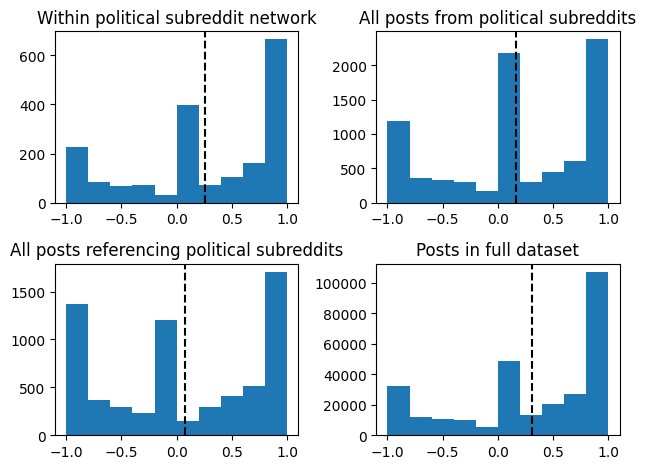

In [7]:
dfs = [df, df_psource, df_ptarget, df_full]

fig, axs = plt.subplots(2,2)

for ax, data in zip(axs.flatten(), dfs):
    ax.hist(data['sentiment_compound'])
    ax.axvline(np.mean(data['sentiment_compound']), linestyle='--', color='black')

axs[0][0].set_title("Within political subreddit network")
axs[0][1].set_title("All posts from political subreddits")
axs[1][0].set_title("All posts referencing political subreddits")
axs[1][1].set_title("Posts in full dataset")

plt.tight_layout()
plt.show()

### Post sentiments by louvain community
**When the political subreddits are the source post:**

Communities with more negative posts in dataset than positive: 
- Community 5 (ukpolitics)
- Community 7 (gunpolitics)
- Community 12 (europes)

Most neutral:
- Community 3 (worldpolitics)

All other communities have majority positive posts. 

----------------------------------------------


**When the political subreddits are the target post:**
- Many of the sentiment distributions shift to be more negative when political subreddits are the ones hyperlinked
- The exception to this are Community 5 and 12 (related to European politics) which show the opposite effect - the distribution shifts to be more positive.

NOTE: these are relatively small sample sizes when dividing by community.

			VADER SENTIMENT BY COMMUNITY 





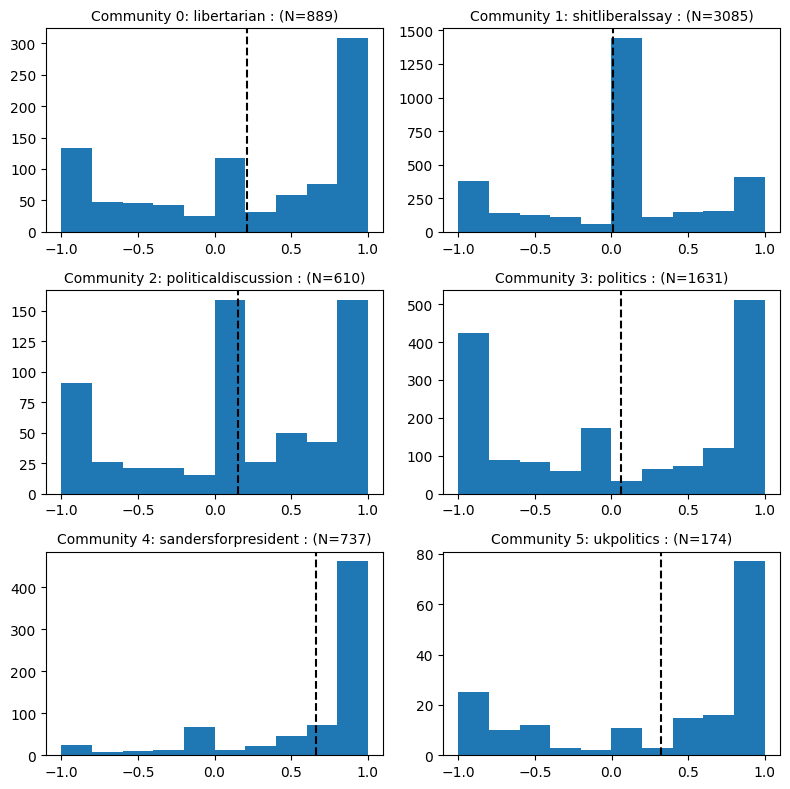

In [8]:
def plot_avg_sentiment(df, sentiment):
    fig, axs = plt.subplots(len(communities)//2,2, figsize=(8,8))
    flat_ax = axs.flatten()
    
    for i, comm in enumerate(communities):
        idx_source = df[source].isin(comm)
        x_source = df[idx_source][f'sentiment_{sentiment}']
        flat_ax[i].hist(x_source)
        flat_ax[i].axvline(np.mean(x_source), linestyle='--', color="black")
        flat_ax[i].set_title(f'Community {i}: {community_labels[i][0]} : (N={len(x_source)})', fontdict={'fontsize': 10})
        ax.set_xlim([-1, 1])

    plt.tight_layout()
    plt.show()
    
print("\t\t\tVADER SENTIMENT BY COMMUNITY \n\n\n")

plot_avg_sentiment(df_full, 'compound')

## Hyperlink sentiments

In [9]:
253/(1780 + 253)
21070/(265491 + 21070)

0.07352710243194294

LINK_SENTIMENT
 1    1649
-1     238
Name: count, dtype: int64 


LINK_SENTIMENT
 1    7040
-1    1195
Name: count, dtype: int64 


LINK_SENTIMENT
 1    5618
-1     933
Name: count, dtype: int64 


LINK_SENTIMENT
 1    265491
-1     21070
Name: count, dtype: int64 




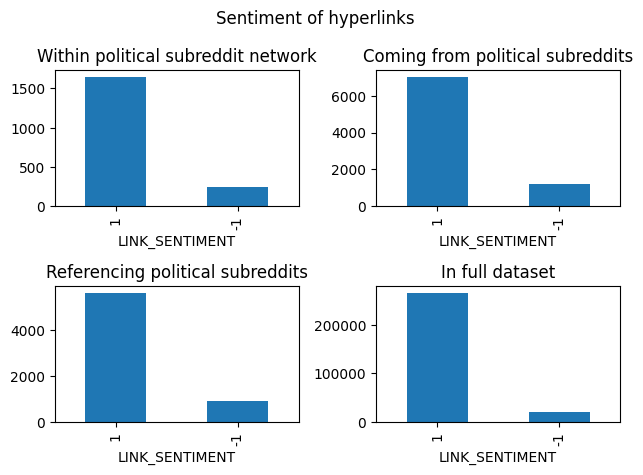

In [10]:
def sentiment_value_counts(df, ax):
    value_counts = df['LINK_SENTIMENT'].value_counts()
    print(value_counts, "\n\n")
    df['LINK_SENTIMENT'].value_counts().plot(kind='bar', ax=ax)
    
fig, axs = plt.subplots(2,2)

for ax, data in zip(axs.flatten(), [df, df_psource, df_ptarget, df_full]):
    sentiment_value_counts(data, ax)

axs[0][0].set_title("Within political subreddit network")
axs[0][1].set_title("Coming from political subreddits")
axs[1][0].set_title("Referencing political subreddits")
axs[1][1].set_title("In full dataset")
plt.suptitle("Sentiment of hyperlinks")
plt.tight_layout()
plt.show()

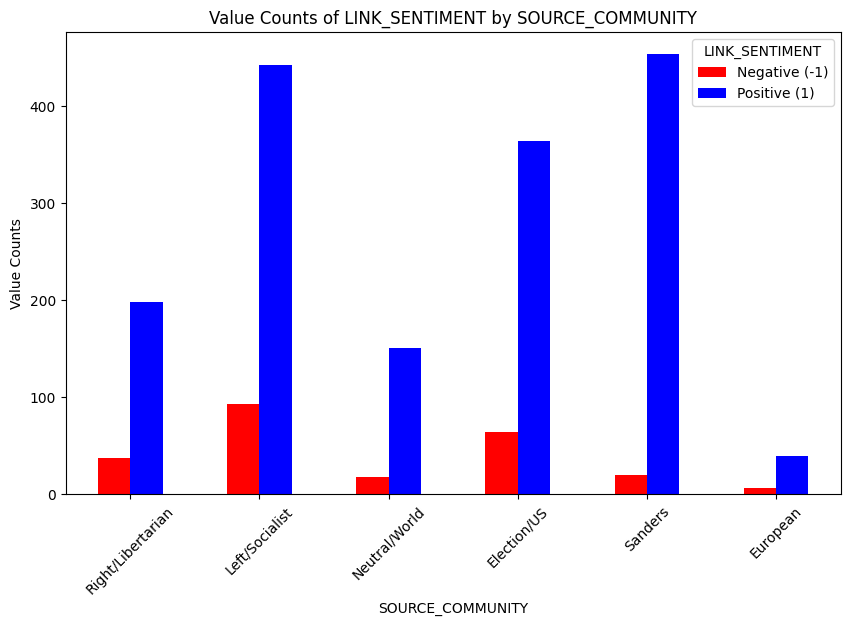

In [11]:
temp = df.groupby(by='SOURCE_COMMUNITY')['LINK_SENTIMENT'].value_counts()

temp = pd.Series(temp).unstack().fillna(0)  # Unstack to get LINK_SENTIMENT in columns
temp.index = temp.index.astype(int)  # Convert index to integers for sorting
temp = temp.sort_index()  # Sort by SOURCE_COMMUNITY for a cleaner plot
temp = temp.rename(index=manual_community_labels)
temp.plot(kind='bar', stacked=False, color=['red', 'blue'], figsize=(10, 6))
plt.xlabel('SOURCE_COMMUNITY')
plt.xticks(rotation=45)
plt.ylabel('Value Counts')
plt.title('Value Counts of LINK_SENTIMENT by SOURCE_COMMUNITY')
plt.legend(title='LINK_SENTIMENT', labels=['Negative (-1)', 'Positive (1)'])
plt.show()

## Networks by sentiment

### Political network graph

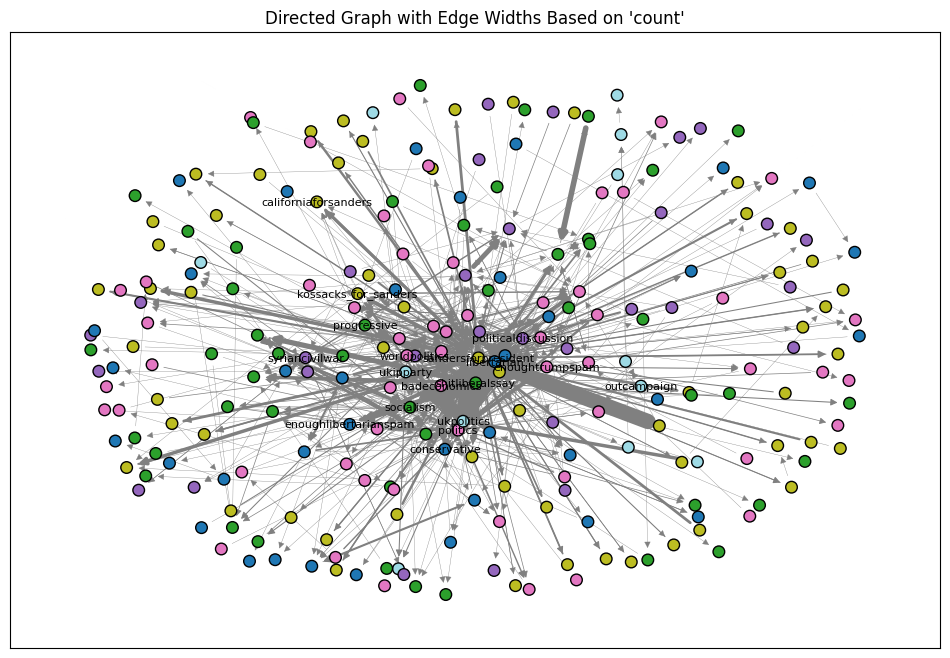

In [12]:
plt.figure(figsize=(12, 8))

# define colors 
colors = plt.get_cmap('tab20', len(communities))
nodes = G_undirected.nodes()
node_color_list = [colors(G_undirected.nodes[n]['community']) for n in nodes]

pos = nx.spring_layout(G_directed, seed=42, k=0.5, scale=40)
label_pos = {node: (x, y - 0.1) for node, (x, y) in pos.items()}

nx.draw_networkx_nodes(G_directed, pos, node_size=70, node_color=node_color_list, edgecolors="black")
nx.draw_networkx_labels(G_directed, label_pos, 
                        labels={node: node for node in sum(community_labels.values(),[])},
                        font_size=8, font_color="black")

# edge widths related to count attribute
edge_widths = [d['count']/4 for (_, _, d) in G_directed.edges(data=True)]

# draw edges
nx.draw_networkx_edges(G_directed, pos, edge_color="gray", arrows=True, width=edge_widths)

plt.title("Directed Graph with Edge Widths Based on 'count'")
plt.show()

### Network of Negative Hyperlinks in Political Graph

In [13]:
# create graph from political network with negative edges
edgelist = df.loc[:, [source, target, "LINK_SENTIMENT"]].copy()
negative_edges = edgelist[edgelist['LINK_SENTIMENT'] == -1]
negative_edges_df = negative_edges.drop_duplicates().copy()
negative_edges_df["count"] = negative_edges.groupby([source, target]).transform("size")
G_negative_edges = nx.from_pandas_edgelist(negative_edges_df, 
                                     source=source, target=target, 
                                     create_using=nx.DiGraph(),
                                     edge_attr=["count"])

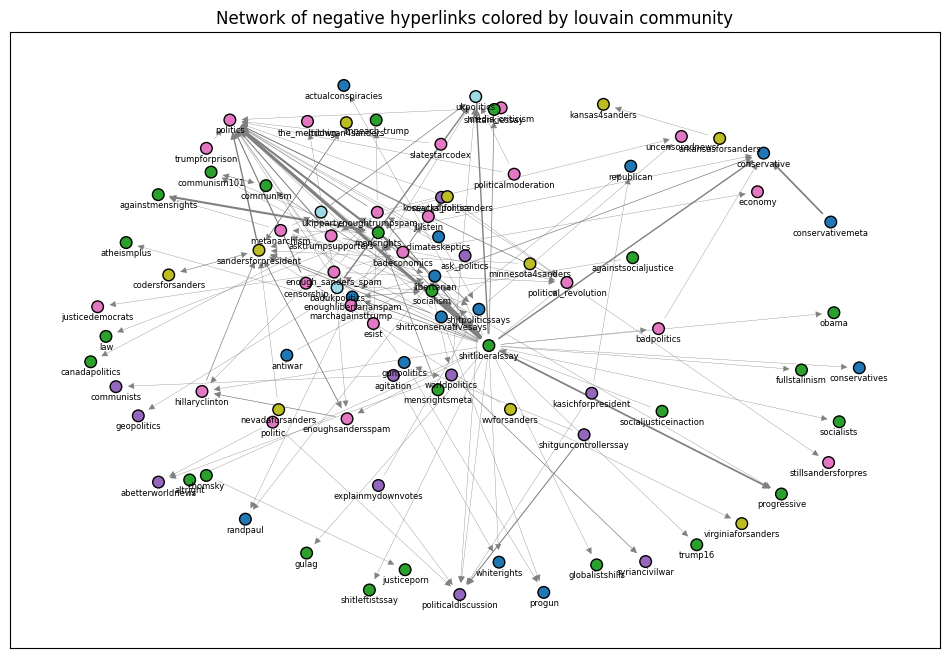

In [14]:
# Set up the plot
plt.figure(figsize=(12, 8))

# define colors 
colors = plt.get_cmap('tab20', len(communities))
node_colors = {}
for i, community in enumerate(communities):
    for node in community:
        node_colors[node] = colors(i) 

# draw nodes with community colors
node_color_list = [node_colors.get(node, 'grey') for node in G_negative_edges.nodes()]

pos = nx.spring_layout(G_negative_edges, seed=42, k=0.5, scale=8)
label_pos = {node: (x, y - 0.3) for node, (x, y) in pos.items()}

nx.draw_networkx_nodes(G_negative_edges, pos, node_size=70, node_color=node_color_list, edgecolors="black")
nx.draw_networkx_labels(G_negative_edges, label_pos, 
                        labels={node: node for node in G_negative_edges.nodes},
                        font_size=6, font_color="black")

# edge widths related to count attribute
edge_widths = [d['count']/4 for (_, _, d) in G_negative_edges.edges(data=True)]

# draw edges
nx.draw_networkx_edges(G_negative_edges, pos, edge_color="gray", arrows=True, width=edge_widths)

plt.title("Network of negative hyperlinks colored by louvain community")
plt.show()

### Network of positive hyperlinks in political network graph

In [15]:
# create graph from political network with positive edges
edgelist = df.loc[:, [source, target, "LINK_SENTIMENT"]].copy()
positive_edges = edgelist[edgelist['LINK_SENTIMENT'] == 1]
positive_edges_df = positive_edges.drop_duplicates().copy()
positive_edges_df["count"] = positive_edges.groupby([source, target]).transform("size")
G_positive_edges = nx.from_pandas_edgelist(positive_edges_df, 
                                     source=source, target=target, 
                                     create_using=nx.DiGraph(),
                                     edge_attr=["count"])

In [16]:
top_pos_df = edgelist_df.sort_values("POSITIVE", ascending=False).iloc[:50,:]
most_connected = set(np.hstack((top_pos_df[source].unique(),top_pos_df[target].unique())))

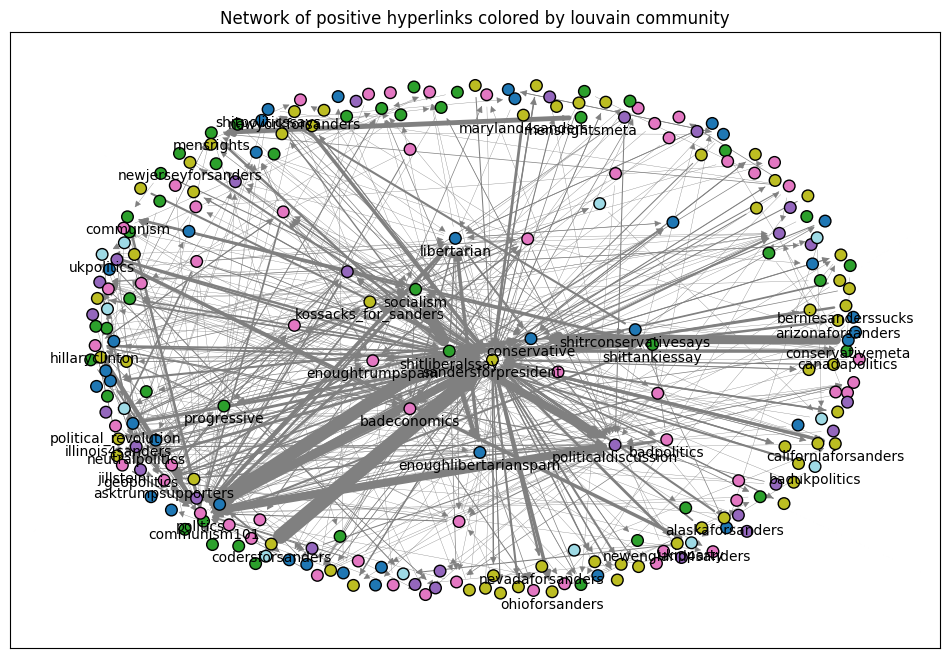

In [17]:
# Set up the plot
plt.figure(figsize=(12, 8))

# define colors 
colors = plt.get_cmap('tab20', len(communities))
node_colors = {}
for i, community in enumerate(communities):
    for node in community:
        node_colors[node] = colors(i) 

# draw nodes with community colors
node_color_list = [node_colors.get(node, 'grey') for node in G_positive_edges.nodes()]

top_pos_df = edgelist_df.sort_values("POSITIVE", ascending=False).iloc[:50,:]
most_connected = set(np.hstack((top_pos_df[source].unique(),top_pos_df[target].unique())))

pos = nx.spring_layout(G_positive_edges, seed=42, k=1.2, scale=2)
label_pos = {node: (x, y - 0.1) for node, (x, y) in pos.items()}

nx.draw_networkx_nodes(G_positive_edges, pos, node_size=70, node_color=node_color_list, edgecolors="black")
nx.draw_networkx_labels(G_positive_edges, label_pos, 
                        labels={node: node for node in most_connected},
                        font_size=10, font_color="black")

# edge widths related to count attribute
edge_widths = [d['count']/4 for (_, _, d) in G_positive_edges.edges(data=True)]

# draw edges
nx.draw_networkx_edges(G_positive_edges, pos, edge_color="gray", arrows=True, width=edge_widths)

plt.title("Network of positive hyperlinks colored by louvain community")
plt.show()

### Network with all negative hyperlinks targeting political subs

In [18]:
# create graph from subreddits negatively linking a political sub
edgelist = df_ptarget.loc[:, [source, target, "LINK_SENTIMENT"]].copy()
negative_edges = edgelist[edgelist['LINK_SENTIMENT'] == -1]
negative_edges_df = negative_edges.drop_duplicates().copy()
negative_edges_df["count"] = negative_edges.groupby([source, target]).transform("size")
G_nt = nx.from_pandas_edgelist(negative_edges_df, 
                                     source=source, target=target, 
                                     create_using=nx.DiGraph(),
                                     edge_attr=["count"])

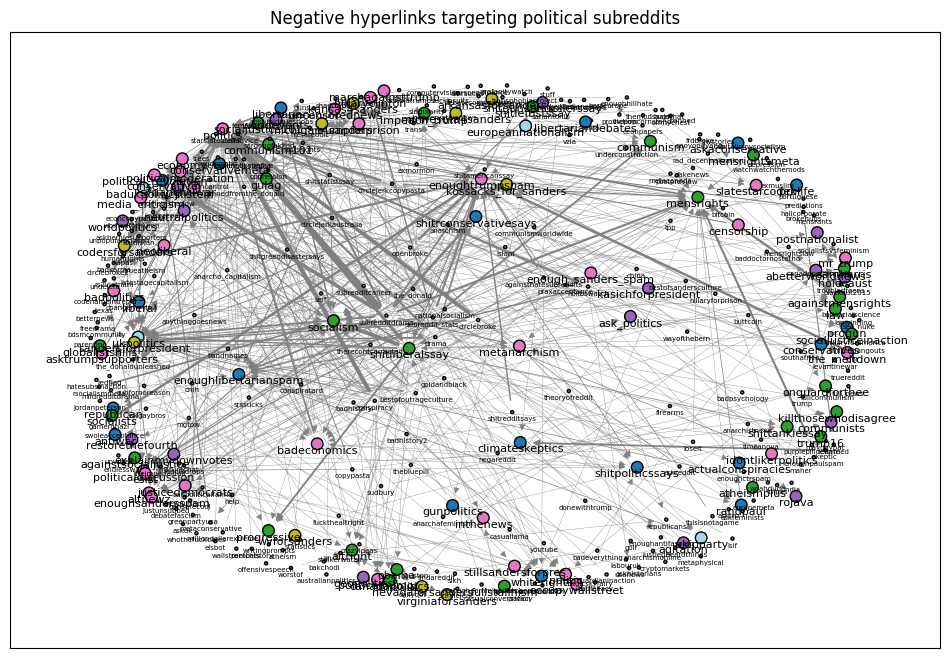

In [19]:
# Set up the plot
plt.figure(figsize=(12, 8))

# define colors 
colors = plt.get_cmap('tab20', len(communities))
node_colors = {}
for i, community in enumerate(communities):
    for node in community:
        node_colors[node] = colors(i) 

# draw nodes with community colors
node_color_list = [node_colors.get(node, 'grey') for node in G_nt.nodes()]

node_sizes = [5 if color == 'grey' else 70 for color in node_color_list]
font_sizes = [5 if color == 'grey' else 8 for color in node_color_list]

pos = nx.spring_layout(G_nt, seed=42, k=0.8, scale=2)
label_pos = {node: (x, y - 0.1) for node, (x, y) in pos.items()}

nx.draw_networkx_nodes(G_nt, pos, node_size=node_sizes, node_color=node_color_list, edgecolors="black")
# Define the positions and labels
labels = {node: node for node in G_nt.nodes()}

# Loop over nodes and draw each label with the appropriate font size
for i, (node, (x, y)) in enumerate(pos.items()):
    # Set font size based on node size
    font_size = 5 if node_sizes[i] == 5 else 8
    plt.text(x, y - 0.05, labels[node], fontsize=font_size, ha='center', va='center', color="black")
##

# edge widths related to count attribute
edge_widths = [d['count']/4 for (_, _, d) in G_nt.edges(data=True)]

# draw edges
nx.draw_networkx_edges(G_nt, pos, edge_color="gray", arrows=True, width=edge_widths)

plt.title("Negative hyperlinks targeting political subreddits")
plt.show()

### Network with all positive hyperlinks targeting political subs

In [20]:
# create graph from subreddits positively linking a political sub
edgelist = df_ptarget.loc[:, [source, target, "LINK_SENTIMENT"]].copy()
positive_edges = edgelist[edgelist['LINK_SENTIMENT'] == 1]
positive_edges_df = positive_edges.drop_duplicates().copy()
positive_edges_df["count"] = positive_edges.groupby([source, target]).transform("size")
G_pt = nx.from_pandas_edgelist(positive_edges_df, 
                                     source=source, target=target, 
                                     create_using=nx.DiGraph(),
                                     edge_attr=["count"])

/var/folders/4b/qn1lg6_d6gj25p55qpkg8lhw0000gn/T/ipykernel_16848/2964842713.py:56: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('Greys')


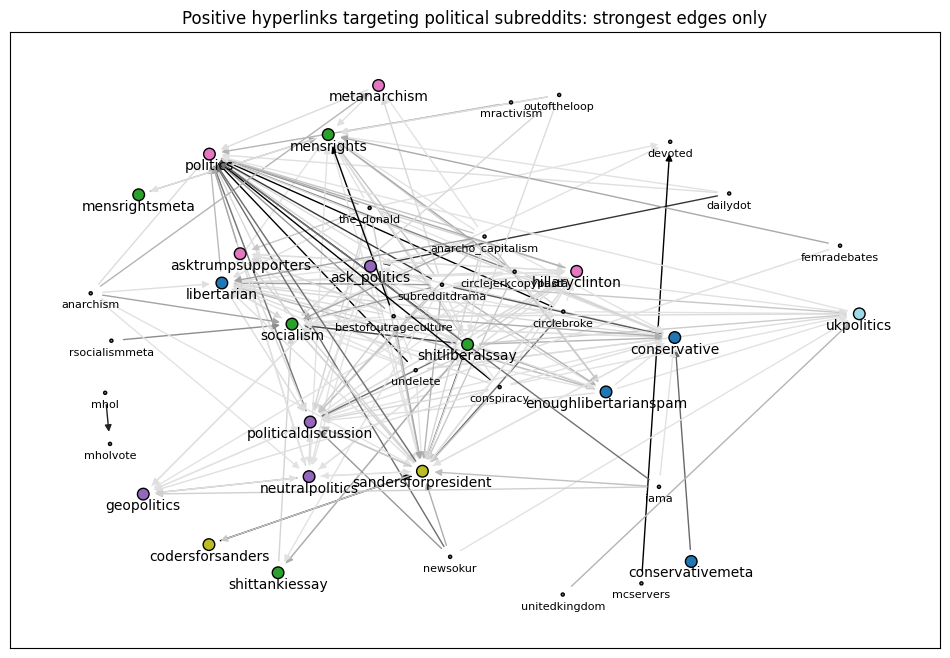

In [21]:
# Set up the plot
plt.figure(figsize=(12, 8))

# Define colors
colors = plt.get_cmap('tab20', len(communities))
node_colors = {}
for i, community in enumerate(communities):
    for node in community:
        node_colors[node] = colors(i)

# Filter out grey nodes (i.e., only keep nodes in the communities)
non_grey_nodes = [node for node in G_pt.nodes() if node in node_colors]

threshold = 10 
strong_edges = [(u, v, d) for u, v, d in G_pt.edges(data=True) if d['count'] > threshold]
strong_nodes = list(pd.DataFrame(strong_edges).drop(columns=2).stack().unique())

# Create a new graph with only the non-grey nodes and strong edges
G_filtered = G_pt.subgraph(strong_nodes).copy()
G_filtered.add_edges_from(strong_edges)

# Recompute positions for the filtered graph
pos = nx.spring_layout(G_filtered, seed=42, k=1.5, scale=5)

# Assign node colors and sizes for the filtered graph
node_color_list = [node_colors.get(node, 'grey') for node in G_filtered.nodes()]
node_sizes = [5 if color == 'grey' else 70 for color in node_color_list]
font_sizes = [5 if color == 'grey' else 8 for color in node_color_list]

# Define the positions and labels
labels = {node: node for node in G_filtered.nodes()}

# Draw nodes with community colors
nx.draw_networkx_nodes(G_filtered, pos, node_size=node_sizes, node_color=node_color_list, edgecolors="black")

# Loop over nodes and draw each label with the appropriate font size
for i, (node, (x, y)) in enumerate(pos.items()):
    font_size = 8 if node_sizes[i] == 5 else 10
    plt.text(x, y - 0.2, labels[node], fontsize=font_size, ha='center', va='center', color="black")

# # Edge widths related to count attribute (in the filtered graph)
# edge_widths = [d['count'] / 4 for (_, _, d) in G_filtered.edges(data=True)]

# # Draw edges with widths based on count
# nx.draw_networkx_edges(G_filtered, pos, edge_color="gray", arrows=True, width=edge_widths)

# Edge colors related to count attribute (gray to black gradient)
edge_counts = [d['count'] for (_, _, d) in G_filtered.edges(data=True)]
max_count = max(edge_counts)
min_count = min(edge_counts)

# Normalize edge weights for colormap
edge_colors = [(count - min_count) / (max_count - min_count) + 0.2 for count in edge_counts]

# Use a grayscale colormap for edges
cmap = plt.cm.get_cmap('Greys')

# Draw edges
nx.draw_networkx_edges(
    G_filtered, pos, 
    edge_color=[cmap(color) for color in edge_colors], 
    arrows=True, width=1  # Set a consistent width for better readability
)


# Set title and show plot
plt.title("Positive hyperlinks targeting political subreddits: strongest edges only")
plt.show()


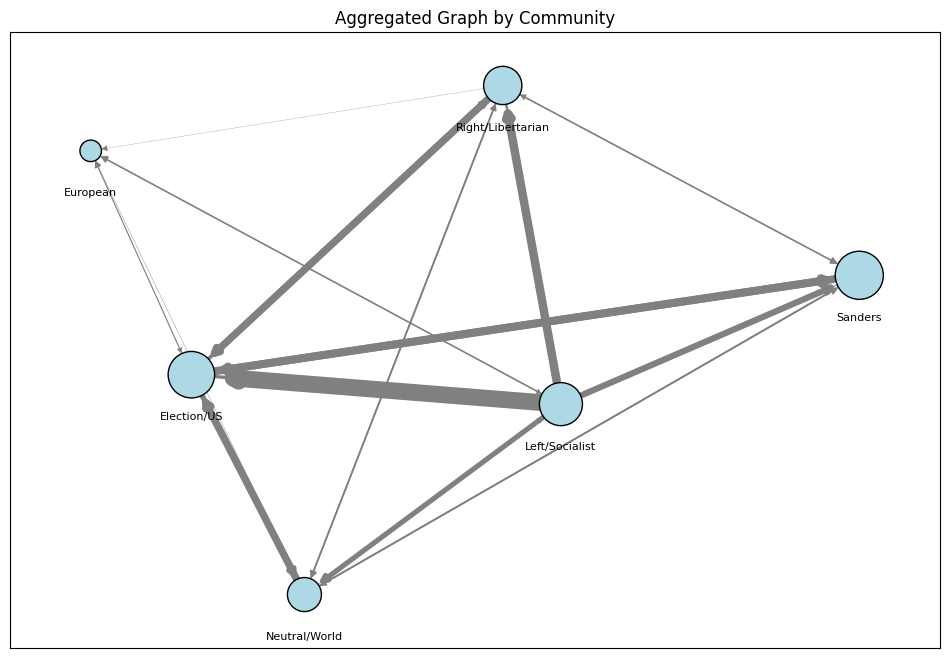

In [22]:
import networkx as nx
import matplotlib.pyplot as plt

# Create a new graph for aggregated communities
G_aggregated = nx.DiGraph()

# Map each node to its community index
node_to_community = {}
for i, community in enumerate(communities):
    for node in community:
        node_to_community[node] = i

# Add aggregated nodes (one for each community)
for i in range(len(communities)):
    G_aggregated.add_node(i, size=len(communities[i]))

# Aggregate edges between communities
for u, v, data in G_directed.edges(data=True):
    weight = data.get('count', 1)  # Default to 1 if 'count' not specified
    u_comm = node_to_community[u]
    v_comm = node_to_community[v]
    if u_comm != v_comm:  # Ignore intra-community edges
        if G_aggregated.has_edge(u_comm, v_comm):
            G_aggregated[u_comm][v_comm]['weight'] += weight
        else:
            G_aggregated.add_edge(u_comm, v_comm, weight=weight)

# Visualize the aggregated graph
plt.figure(figsize=(12, 8))

# Define node colors and sizes
colors = plt.get_cmap('tab20', len(communities))
node_colors = [colors(i) for i in range(len(communities))]
node_sizes = [G_aggregated.nodes[n]['size'] * 20 for n in G_aggregated.nodes()]

# Define edge widths based on weights
edge_widths = [d['weight'] / 10 for (_, _, d) in G_aggregated.edges(data=True)]

# Layout and draw the graph
pos = nx.spring_layout(G_aggregated, seed=42, k=10, scale=1)
label_pos = {node: (x, y - 0.15) for node, (x, y) in pos.items()}

nx.draw_networkx_nodes(G_aggregated, pos, node_size=node_sizes, node_color="lightblue", edgecolors="black")
nx.draw_networkx_labels(G_aggregated, label_pos, 
                        #labels={key: "\n".join(val) for key, val in community_labels.items()}, #{node: f"Comm {node}" for node in G_aggregated.nodes()},
                        labels=manual_community_labels,
                        font_size=8, font_color="black")
nx.draw_networkx_edges(G_aggregated, pos, node_size=node_sizes, edge_color="gray", arrows=True, width=edge_widths)

plt.title("Aggregated Graph by Community")
plt.show()


## Sentiment metrics

In [23]:
# MOST NEGATIVE LINKS: TARGET
idx_negative = df['LINK_SENTIMENT'] == -1
df.loc[idx_negative, [target, "LINK_SENTIMENT"]].value_counts(target)[:10]

TARGET_SUBREDDIT
politics               49
socialism              19
sandersforpresident    13
ukpolitics             13
conservative           13
mensrights             10
enoughtrumpspam         9
politicaldiscussion     8
libertarian             7
progressive             6
Name: count, dtype: int64

In [24]:
# MOST POSITIVE LINKS: TARGET
idx_positive = df['LINK_SENTIMENT'] == 1
df.loc[idx_positive, [target, "LINK_SENTIMENT"]].value_counts(target)[:10]

TARGET_SUBREDDIT
sandersforpresident    380
politics               262
socialism               86
politicaldiscussion     82
conservative            67
libertarian             35
ukpolitics              34
hillaryclinton          29
mensrights              27
geopolitics             27
Name: count, dtype: int64

In [25]:
# MOST NEGATIVE LINKS: SOURCE
idx_negative = df['LINK_SENTIMENT'] == -1
df.loc[idx_negative, [source, "LINK_SENTIMENT"]].value_counts(source)[:10]

SOURCE_SUBREDDIT
shitliberalssay          66
badeconomics             13
libertarian              12
sandersforpresident       9
asktrumpsupporters        9
socialism                 8
shitrconservativesays     7
enoughtrumpspam           6
enough_sanders_spam       6
againstmensrights         6
Name: count, dtype: int64

In [26]:
# MOST POSITIVE LINKS: SOURCE
idx_positive = df['LINK_SENTIMENT'] == 1
df.loc[idx_positive, [source, "LINK_SENTIMENT"]].value_counts(source)[:10]

SOURCE_SUBREDDIT
shitliberalssay        274
sandersforpresident    157
codersforsanders        44
asktrumpsupporters      44
politicaldiscussion     42
libertarian             40
badeconomics            36
enoughtrumpspam         35
socialism               32
hillaryclinton          30
Name: count, dtype: int64

In [27]:
community_labels

{0: ['libertarian', 'conservative', 'enoughlibertarianspam'],
 1: ['shitliberalssay', 'socialism', 'progressive'],
 2: ['politicaldiscussion', 'syriancivilwar', 'worldpolitics'],
 3: ['politics', 'enoughtrumpspam', 'badeconomics'],
 4: ['sandersforpresident', 'kossacks_for_sanders', 'californiaforsanders'],
 5: ['ukpolitics', 'ukipparty', 'outcampaign']}

In [28]:
# NUMBER OF LINKS BETWEEN COMMUNITIES
links_df = df[['SOURCE_COMMUNITY','TARGET_COMMUNITY','LINK_SENTIMENT']].value_counts().reset_index()
links_df

,SOURCE_COMMUNITY,TARGET_COMMUNITY,LINK_SENTIMENT,count
0,4,4,1,387
1,3,3,1,229
2,1,1,1,212
3,0,0,1,120
4,1,3,1,100
5,2,2,1,75
6,3,4,1,55
7,2,3,1,50
8,1,1,-1,48
9,4,3,1,47


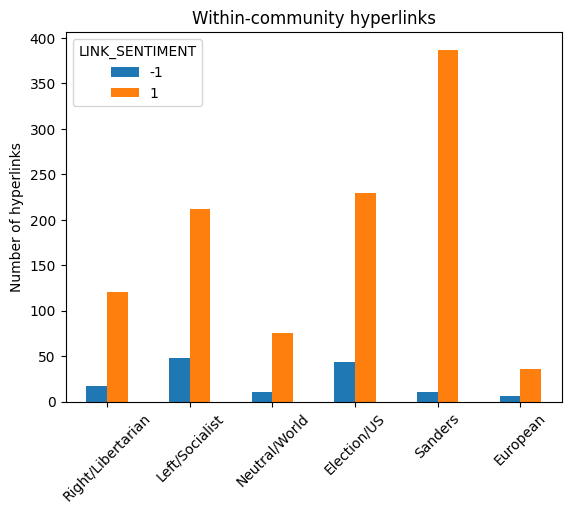

In [29]:
hyperlink_df = links_df.pivot_table(index=['SOURCE_COMMUNITY','TARGET_COMMUNITY'], 
                     columns='LINK_SENTIMENT', values='count', fill_value=0).reset_index()

## LINKS WITHIN COMMUNITIES
plot_df = hyperlink_df[hyperlink_df['SOURCE_COMMUNITY'] == hyperlink_df['TARGET_COMMUNITY']].reset_index()

plot_df.rename(index=manual_community_labels).plot.bar(y=[-1,1]);
plt.xticks(rotation=45)
plt.title("Within-community hyperlinks")
plt.ylabel("Number of hyperlinks")
plt.show()

In [30]:
## Most negative links within themselves
plot_df['percent_negative'] = plot_df[-1]/(plot_df[-1] + plot_df[1])
plot_df[['SOURCE_COMMUNITY','percent_negative']].sort_values(by='percent_negative', ascending=False)

LINK_SENTIMENT,SOURCE_COMMUNITY,percent_negative
1,1,0.184615
3,3,0.161172
5,5,0.142857
0,0,0.124088
2,2,0.117647
4,4,0.027638


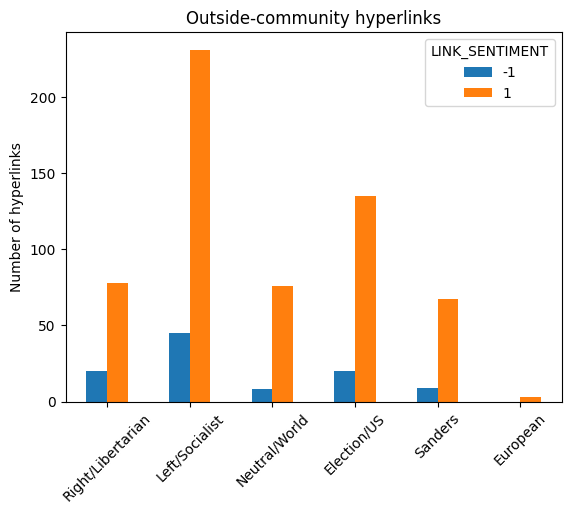

In [31]:
## LINKS OUTSIDE OF COMMUNITY
temp = hyperlink_df[~(hyperlink_df['SOURCE_COMMUNITY'] == hyperlink_df['TARGET_COMMUNITY'])].reset_index()

plot_df = temp.groupby(by='SOURCE_COMMUNITY')[[-1,1]].sum().reset_index().rename(index=manual_community_labels)

plot_df.plot.bar(y=[-1,1]);
plt.title("Outside-community hyperlinks")
plt.xticks(rotation=45)
plt.ylabel("Number of hyperlinks")
plt.show()

In [32]:
## Most negative links outside themselves
plot_df['percent_negative'] = plot_df[-1]/(plot_df[-1] + plot_df[1])
plot_df[['SOURCE_COMMUNITY','percent_negative']].sort_values(by='percent_negative', ascending=False).reset_index().drop(columns="index")

LINK_SENTIMENT,SOURCE_COMMUNITY,percent_negative
0,0,0.204082
1,1,0.163043
2,3,0.129032
3,4,0.118421
4,2,0.095238
5,5,0.000000


In [33]:
within_comm_df = hyperlink_df[hyperlink_df['SOURCE_COMMUNITY'] == hyperlink_df['TARGET_COMMUNITY']].reset_index()


temp = hyperlink_df[~(hyperlink_df['SOURCE_COMMUNITY'] == hyperlink_df['TARGET_COMMUNITY'])].reset_index()

outside_comm_df = temp.groupby(by='SOURCE_COMMUNITY')[[-1,1]].sum().reset_index()

In [34]:
within_comm_df = within_comm_df[['SOURCE_COMMUNITY', -1,1]]
outside_comm_df = outside_comm_df[['SOURCE_COMMUNITY', -1,1]]
within_comm_df.columns = ['SOURCE_COMMUNITY', 'within(-1)', 'within(1)']
outside_comm_df.columns = ['SOURCE_COMMUNITY', 'outside(-1)', 'outside(1)']
merged_df = within_comm_df.merge(outside_comm_df, on='SOURCE_COMMUNITY', how='inner')
# merged_df.fillna(0, inplace=True)

In [35]:
merged_df[['SOURCE_COMMUNITY','within(1)','within(-1)','outside(1)','outside(-1)']].astype(int)

,SOURCE_COMMUNITY,within(1),within(-1),outside(1),outside(-1)
0,0,120,17,78,20
1,1,212,48,231,45
2,2,75,10,76,8
3,3,229,44,135,20
4,4,387,11,67,9
5,5,36,6,3,0


In [36]:
merged_df['within(% neg)'] = merged_df['within(-1)'] / (merged_df['within(1)'] + merged_df['within(-1)'])
merged_df['outside(% neg)'] = merged_df['outside(-1)'] / (merged_df['outside(1)'] + merged_df['outside(-1)'])

merged_df['within(% neg)'] - merged_df['outside(% neg)'] 

0   -0.079994
1    0.021572
2    0.022409
3    0.032140
4   -0.090783
5    0.142857
dtype: float64

In [37]:
merged_df["% links within community"] = (merged_df['within(-1)'] + merged_df['within(1)']) / (merged_df['outside(-1)'] + merged_df['outside(1)'] + (merged_df['within(-1)'] + merged_df['within(1)']))

In [38]:
merged_df

,SOURCE_COMMUNITY,within(-1),within(1),outside(-1),outside(1),within(% neg),outside(% neg),% links within community
0,0,17.0,120.0,20.0,78.0,0.124088,0.204082,0.582979
1,1,48.0,212.0,45.0,231.0,0.184615,0.163043,0.485075
2,2,10.0,75.0,8.0,76.0,0.117647,0.095238,0.502959
3,3,44.0,229.0,20.0,135.0,0.161172,0.129032,0.637850
4,4,11.0,387.0,9.0,67.0,0.027638,0.118421,0.839662
5,5,6.0,36.0,0.0,3.0,0.142857,0.000000,0.933333


In [39]:
# add community size to dataframe
from collections import Counter
comm_size = pd.DataFrame.from_dict(Counter(partition.values()), orient='index').reset_index()
comm_size.columns = ["SOURCE_COMMUNITY", "size"]
merged_df.merge(comm_size, how='inner', on='SOURCE_COMMUNITY')

,SOURCE_COMMUNITY,within(-1),within(1),outside(-1),outside(1),within(% neg),outside(% neg),% links within community,size
0,0,17.0,120.0,20.0,78.0,0.124088,0.204082,0.582979,38
1,1,48.0,212.0,45.0,231.0,0.184615,0.163043,0.485075,48
2,2,10.0,75.0,8.0,76.0,0.117647,0.095238,0.502959,30
3,3,44.0,229.0,20.0,135.0,0.161172,0.129032,0.637850,56
4,4,11.0,387.0,9.0,67.0,0.027638,0.118421,0.839662,60
5,5,6.0,36.0,0.0,3.0,0.142857,0.000000,0.933333,12


Subs with high in-degree centrality include both neutral and partisan reddits (partisan reddits likely comment on neutral posts with opinions)

In [40]:
in_degree = sorted(nx.in_degree_centrality(G_directed).items(), key=lambda item:item[1], reverse=True)
pd.DataFrame(in_degree[:15], columns=["subreddit","in_degree_centrality"])

,subreddit,in_degree_centrality
0,sandersforpresident,0.362140
1,politics,0.288066
2,politicaldiscussion,0.131687
3,conservative,0.106996
4,socialism,0.106996
5,hillaryclinton,0.074074
6,libertarian,0.069959
7,syriancivilwar,0.069959
8,political_revolution,0.069959
9,enoughtrumpspam,0.053498


Most subs with high out-degree centrality are non-neutral:

In [41]:
out_degree = sorted(nx.out_degree_centrality(G_directed).items(), key=lambda item:item[1], reverse=True)
pd.DataFrame(out_degree[:15], columns=["subreddit","out_degree_centrality"])

,subreddit,out_degree_centrality
0,shitliberalssay,0.251029
1,sandersforpresident,0.218107
2,badeconomics,0.082305
3,libertarian,0.078189
4,socialism,0.074074
5,enoughtrumpspam,0.074074
6,asktrumpsupporters,0.061728
7,politicaldiscussion,0.053498
8,shitrconservativesays,0.053498
9,enoughlibertarianspam,0.049383


In [42]:
agg_out = sorted(nx.out_degree_centrality(G_aggregated).items(), key=lambda item:item[1], reverse=True)
agg_in = sorted(nx.in_degree_centrality(G_aggregated).items(), key=lambda item:item[1], reverse=True)
agg_cent = pd.DataFrame(agg_out, columns = ["community", "out_degree_centrality"])
agg_cent["in_degree_centrality"] = [item[1] for item in agg_in]
agg_cent

,community,out_degree_centrality,in_degree_centrality
0,0,1.0,1.0
1,1,1.0,1.0
2,2,1.0,1.0
3,3,1.0,0.8
4,4,0.8,0.8
5,5,0.6,0.8


## Identify echo chambers

In [53]:
echo_df = df[["SOURCE_SUBREDDIT", "TARGET_SUBREDDIT", "LINK_SENTIMENT",
              "SOURCE_COMMUNITY","TARGET_COMMUNITY",
             "SOURCE_COMMUNITY_NAME","TARGET_COMMUNITY_NAME"]]

In [54]:
echo_df

,SOURCE_SUBREDDIT,TARGET_SUBREDDIT,LINK_SENTIMENT,SOURCE_COMMUNITY,TARGET_COMMUNITY,SOURCE_COMMUNITY_NAME,TARGET_COMMUNITY_NAME
0,libertarian,conservative,1,0,0,Right/Libertarian,Right/Libertarian
1,communism101,communism,1,1,1,Left/Socialist,Left/Socialist
2,mensrightsmeta,mensrights,1,1,1,Left/Socialist,Left/Socialist
3,politicaldiscussion,politics,1,2,3,Neutral/World,Election/US
4,communism101,socialism,1,1,1,Left/Socialist,Left/Socialist
...,...,...,...,...,...,...,...
1900,thedavidpakmanshow,socialism,1,0,1,Right/Libertarian,Left/Socialist
1901,shitliberalssay,ukpolitics,-1,1,5,Left/Socialist,European
1902,enough_sanders_spam,enoughsandersspam,-1,3,3,Election/US,Election/US
1903,neoliberal,badeconomics,1,3,3,Election/US,Election/US


In [55]:
echo_df.groupby(by='SOURCE_SUBREDDIT').agg(sum).drop(columns="TARGET_SUBREDDIT")

/var/folders/4b/qn1lg6_d6gj25p55qpkg8lhw0000gn/T/ipykernel_16848/419745632.py:1: FutureWarning: The provided callable <built-in function sum> is currently using DataFrameGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  echo_df.groupby(by='SOURCE_SUBREDDIT').agg(sum).drop(columns="TARGET_SUBREDDIT")


,LINK_SENTIMENT,SOURCE_COMMUNITY,TARGET_COMMUNITY,SOURCE_COMMUNITY_NAME,TARGET_COMMUNITY_NAME
SOURCE_SUBREDDIT,,,,,
2016_elections,2,6,6,Election/USElection/US,Election/USElection/US
2016elections,1,3,3,Election/US,Election/US
actualconspiracies,1,0,0,Right/Libertarian,Right/Libertarian
againstmensrights,-3,9,11,Left/SocialistLeft/SocialistLeft/SocialistLeft...,Left/SocialistLeft/SocialistLeft/SocialistLeft...
againstsocialjustice,-1,1,1,Left/Socialist,Left/Socialist
...,...,...,...,...,...
wisconsin4sanders,3,12,12,SandersSandersSanders,SandersSandersSanders
worldevents,1,2,2,Neutral/World,Neutral/World
worldpolitics,7,30,46,Neutral/WorldNeutral/WorldNeutral/WorldNeutral...,Election/USNeutral/WorldEuropeanNeutral/WorldS...


In [56]:
pd.crosstab(echo_df["SOURCE_SUBREDDIT"], echo_df["LINK_SENTIMENT"]).sort_values(by=1, ascending=False)[:20]

LINK_SENTIMENT,-1,1
SOURCE_SUBREDDIT,,
shitliberalssay,66,274
sandersforpresident,9,157
asktrumpsupporters,9,44
codersforsanders,1,44
politicaldiscussion,0,42
libertarian,12,40
badeconomics,13,36
enoughtrumpspam,6,35
socialism,8,32


In [57]:
merged_df

,SOURCE_COMMUNITY,within(-1),within(1),outside(-1),outside(1),within(% neg),outside(% neg),% links within community
0,0,17.0,120.0,20.0,78.0,0.124088,0.204082,0.582979
1,1,48.0,212.0,45.0,231.0,0.184615,0.163043,0.485075
2,2,10.0,75.0,8.0,76.0,0.117647,0.095238,0.502959
3,3,44.0,229.0,20.0,135.0,0.161172,0.129032,0.637850
4,4,11.0,387.0,9.0,67.0,0.027638,0.118421,0.839662
5,5,6.0,36.0,0.0,3.0,0.142857,0.000000,0.933333


In [58]:
import seaborn as sns

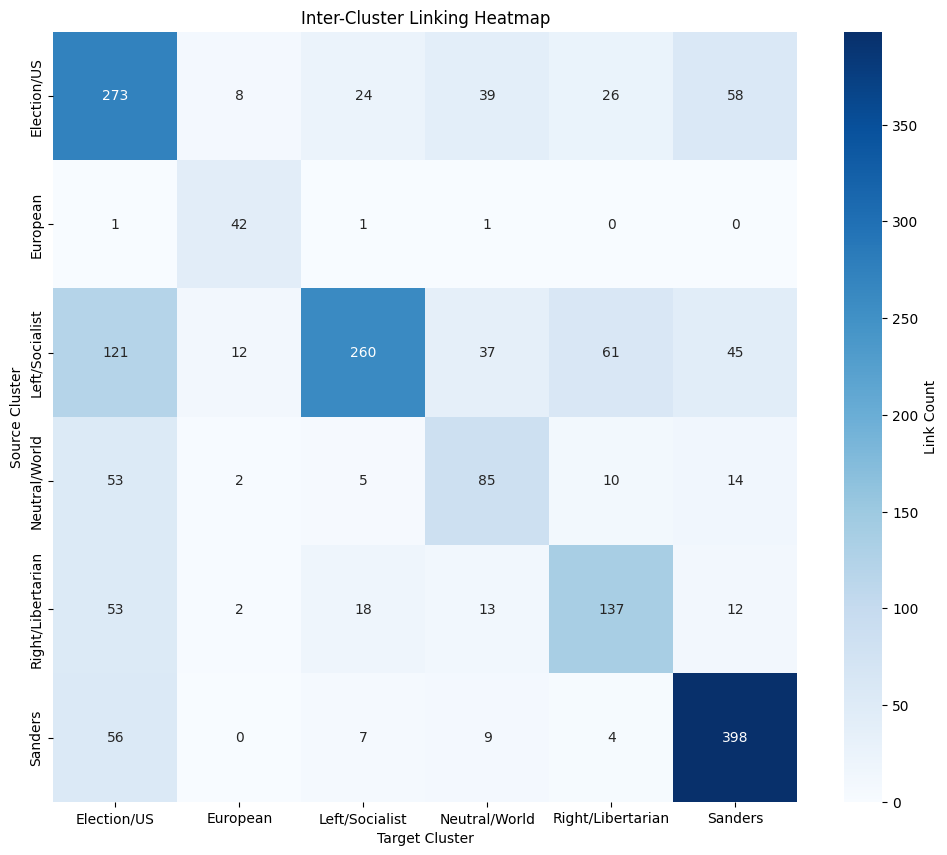

In [61]:
#cols = ['SOURCE_COMMUNITY', 'TARGET_COMMUNITY']
cols = ['SOURCE_COMMUNITY_NAME', 'TARGET_COMMUNITY_NAME']
link_data = echo_df[cols].value_counts(dropna=False).reset_index()

link_matrix = link_data.pivot(columns="TARGET_COMMUNITY_NAME", index="SOURCE_COMMUNITY_NAME", values="count").fillna(0)

plt.figure(figsize=(12, 10))
sns.heatmap(link_matrix, cmap='Blues', annot=True, fmt=".0f", cbar_kws={'label': 'Link Count'})
plt.title("Inter-Cluster Linking Heatmap")
plt.xlabel("Target Cluster")
plt.ylabel("Source Cluster")
plt.show()

In [60]:
[", ".join(c) for c in communities]

['libertarian, randpaul, gunpolitics, enoughlibertarianspam, libertarianpartyohio, whiterights, new_right, conservativelounge, conservativemeta, conservatives, antiwar, prolife, prochoice, nevertrump, acteuropa, climateskeptics, askaconservative, geolibertarianism, shitpoliticssays, libertarianpartyusa, liberal, austrian_economics, republican, newjerseylibertarians, progun, demsocialist, libertariandebates, thedavidpakmanshow, conservatives_r_us, conservative, paleoconservative, georgism, shitrconservativesays, conservativesonly, theredpillright, daverubin, libertarianmeme, actualconspiracies',
 'socialjusticeinaction, chomsky, socialistprogrammers, shittankiessay, trump16, socialism, obama, law, leftcommunism, gulag, scotus, mormonpolitics, anarchy, socialjustice101, civpolitics, samharris, youngsocialistunited, altright, leftypolitics, fullstalinism, globalistshills, alltheleft, shitliberalssay, mensrightsmeta, justiceporn, socialists, militant, politicalfactchecking, mensrights, cat